In [1]:
%matplotlib widget
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap, BoundaryNorm
import flexorb.utils.keplerian as kp
from importlib import reload

In [2]:
import orekit
vm = orekit.initVM()

In [3]:
from orekit.pyhelpers import setup_orekit_curdir, absolutedate_to_datetime
setup_orekit_curdir(filename = '../../orekit_examples/orekit-data-master')

In [4]:

def count_altitude_events(time, altitude, thresholds):
    """
    Count the number of continuous events where altitude is above each threshold.

    Parameters:
        time (np.ndarray): 1D array of time values.
        altitude (np.ndarray): 1D array of altitude values.
        thresholds (list or np.ndarray): List of altitude thresholds.

    Returns:
        dict: Mapping from threshold to number of events above that threshold.
    """
    if len(time) != len(altitude):
        raise ValueError("Time and altitude arrays must have the same length.")

    event_counts = []
    events_sum = 0

    thresholds.sort()

    for threshold in thresholds[::-1]:
        above = altitude > threshold
        # Detect rising edge: True if this point is True and the previous is False
        events = np.diff(np.concatenate(([False], above.astype(int)))) == 1
        count = int(np.sum(events))
        print('Total events with altitude above {} are {}'.format(threshold, count))
        event_counts.append(count - events_sum)
        if count - events_sum < 0:
            print('RED ALERT')
        events_sum = count

    return event_counts





def classify_array(data, bins, labels):
    """
    Classify each element of the 2D array into a bin defined by 'bins'.
    
    Parameters:
        data (np.ndarray): 2D input array.
        bins (list): Boundaries for classification.
        labels (list): Numeric labels corresponding to each bin.
        
    Returns:
        np.ndarray: 2D array with classified values.
    """
    categorized = np.digitize(data, bins=bins, right=False)
    print(categorized)
    return np.array([labels[labels.index(i)] for i in categorized.flat]).reshape(data.shape)



Now we are set up to import and use objects from the orekit library. Packages can be imported as they were native Python packages

In [5]:
from org.orekit.data import DataProvidersManager, ZipJarCrawler
from org.orekit.frames import FramesFactory, TopocentricFrame
from org.orekit.bodies import OneAxisEllipsoid, GeodeticPoint
from org.orekit.time import TimeScalesFactory, AbsoluteDate, DateComponents, TimeComponents
from org.orekit.utils import IERSConventions, Constants
from org.orekit.utils import PVCoordinatesProvider 


from org.orekit.propagation.analytical.tle import TLE, TLEPropagator
from java.io import File

from math import radians, pi
import pandas as pd
import numpy as np


## Define orbit 

Perform simple TLE propagation, using two strings as input.

In [6]:
tle_line1 = '1 99999U 26000    26088.00000000  .00000000  00000-0  00000-0 2    02'
tle_line2 = '2 99999  97.3171  40.0669 0012579 247.4676 111.8050 15.23054260    04'

ITRF = FramesFactory.getITRF(IERSConventions.IERS_2010, True)
earth = OneAxisEllipsoid(Constants.WGS84_EARTH_EQUATORIAL_RADIUS, 
                         Constants.WGS84_EARTH_FLATTENING, 
                         ITRF)

longitude = radians(23.0)
latitude  = radians(40.05)
altitude  = 341.0
station1 = GeodeticPoint(latitude, longitude, altitude)
sta1Frame = TopocentricFrame(earth, station1, "Esrange")

In [7]:
input_tle = TLE(tle_line1, tle_line2)
mean_n = input_tle.getMeanMotion()
mean_e = input_tle.getE()
mean_i = input_tle.getI()
mean_pa = input_tle.getPerigeeArgument()
mean_raan = input_tle.getRaan()
mean_m = input_tle.getMeanAnomaly()

e

In [8]:
raans = np.arange(-15, 15.1, 7.5)*np.pi/180 + mean_raan

all_events = []

for mean_raan in raans:
    mean_raan = float(mean_raan)
    initialDate = AbsoluteDate(DateComponents(2026, 3, 29),
                            TimeComponents.H00,
                            TimeScalesFactory.getUTC())

    inertialFrame = FramesFactory.getEME2000()

    my_tle = TLE(
        input_tle.getSatelliteNumber(),
        input_tle.getClassification(),
        input_tle.getLaunchYear(),
        input_tle.getLaunchNumber(),
        input_tle.getLaunchPiece(),
        input_tle.getEphemerisType(),
        input_tle.getElementNumber(),
        input_tle.getDate(),
        mean_n,   # Mean Motion
        0.0,      # Mean Motion 1st deriv (optional)
        0.0,      # Mean Motion 2nd deriv (optional)
        mean_e,   # Eccentricity
        mean_i,   # Inclination
        mean_pa,  # Arg of Perigee
        mean_raan,# RAAN
        mean_m,   # Mean Anomaly
        input_tle.getRevolutionNumberAtEpoch(),
        input_tle.getBStar()
    )
    print(f"Line 1: {my_tle.getLine1()}")
    print(f"Line 2: {my_tle.getLine2()}")
    propagator = TLEPropagator.selectExtrapolator(my_tle)

    propagator = PVCoordinatesProvider.cast_(propagator)

    pvs = []
    extrapDate = initialDate
    total_days = 21
    finalDate = extrapDate.shiftedBy(60.0 * 60 * 24 * total_days)  #seconds

    while (extrapDate.compareTo(finalDate) <= 0.0):
        pv = propagator.getPVCoordinates(extrapDate, inertialFrame)
        pvs.append(pv)
        extrapDate = extrapDate.shiftedBy(20.0)

    elevation = np.array([sta1Frame.getElevation(x.getPosition(), inertialFrame, x.getDate())*180.0/pi for x in pvs])
    time = np.array([x.getDate().getJD() for x in pvs])
    n_events = count_altitude_events(time, elevation, [20, 35, 55, 75])
    all_events.append(n_events)

Line 1: 1 99999U 26000    26088.00000000  .00000000  00000-0  00000-0 2    02
Line 2: 2 99999  97.3171  25.0669 0012579 247.4676 111.8050 15.23054260    07
Total events with altitude above 75 are 5
Total events with altitude above 55 are 15
Total events with altitude above 35 are 27
Total events with altitude above 20 are 45
Line 1: 1 99999U 26000    26088.00000000  .00000000  00000-0  00000-0 2    02
Line 2: 2 99999  97.3171  32.5669 0012579 247.4676 111.8050 15.23054260    00
Total events with altitude above 75 are 5
Total events with altitude above 55 are 13
Total events with altitude above 35 are 25
Total events with altitude above 20 are 43
Line 1: 1 99999U 26000    26088.00000000  .00000000  00000-0  00000-0 2    02
Line 2: 2 99999  97.3171  40.0669 0012579 247.4676 111.8050 15.23054260    04
Total events with altitude above 75 are 4
Total events with altitude above 55 are 14
Total events with altitude above 35 are 26
Total events with altitude above 20 are 43
Line 1: 1 99999U 26

In [9]:
all_events = np.array(all_events)
plot_events = all_events.T
plot_events = plot_events / total_days*7

In [10]:
plot_events

array([[1.66666667, 1.66666667, 1.33333333, 2.33333333, 1.66666667],
       [3.33333333, 2.66666667, 3.33333333, 2.33333333, 2.66666667],
       [4.        , 4.        , 4.        , 4.33333333, 5.        ],
       [6.        , 6.        , 5.66666667, 6.33333333, 6.33333333]])

Take the results and populate a Pandas DataFrame with them for managing the results.

In [11]:
def plot_categorized_array(categorized_array, label_descriptions, cmap_colors, xlabels, ylabels):
    """
    Plot a 2D array with colors and values, and a discrete legend.
    
    Parameters:
        categorized_array (np.ndarray): 2D array with category values.
        label_descriptions (dict): Mapping of label -> description.
        cmap_colors (list): List of colors for each category.
    """
    labels = sorted(label_descriptions.keys())
    
    cmap = ListedColormap(cmap_colors)
    norm = BoundaryNorm([x - 0.5 for x in labels] + [labels[-1] + 0.5], cmap.N)
    
    fig, ax = plt.subplots(figsize = (15, 5))
    im = ax.imshow(categorized_array, cmap=cmap, norm=norm)

    for i in range(categorized_array.shape[0]):
        for j in range(categorized_array.shape[1]):
            text = ax.text(j, i, label_descriptions[categorized_array[i, j]],
                           ha="center", va="center", color="black")

    # # Create colorbar with labels
    # cbar = fig.colorbar(im, ax=ax, ticks=labels)
    # cbar.ax.set_yticklabels([label_descriptions[label] for label in labels])
    # cbar.set_label("Category")

    ax.set_xticklabels(xlabels)
    ax.set_yticks(range(len(ylabels)))

    ax.set_yticklabels(ylabels)

    ax.set_xlabel("LTAN")
    ax.set_ylabel("Max Pass Altitude (deg)")
    ax.set_title("Average Passes Per Week")
    plt.tight_layout()
    plt.show()


[[1 1 1 2 1]
 [2 2 2 2 2]
 [3 3 3 3 3]
 [4 4 3 4 4]]


/tmp/ipykernel_151565/3898974247.py:28: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(xlabels)


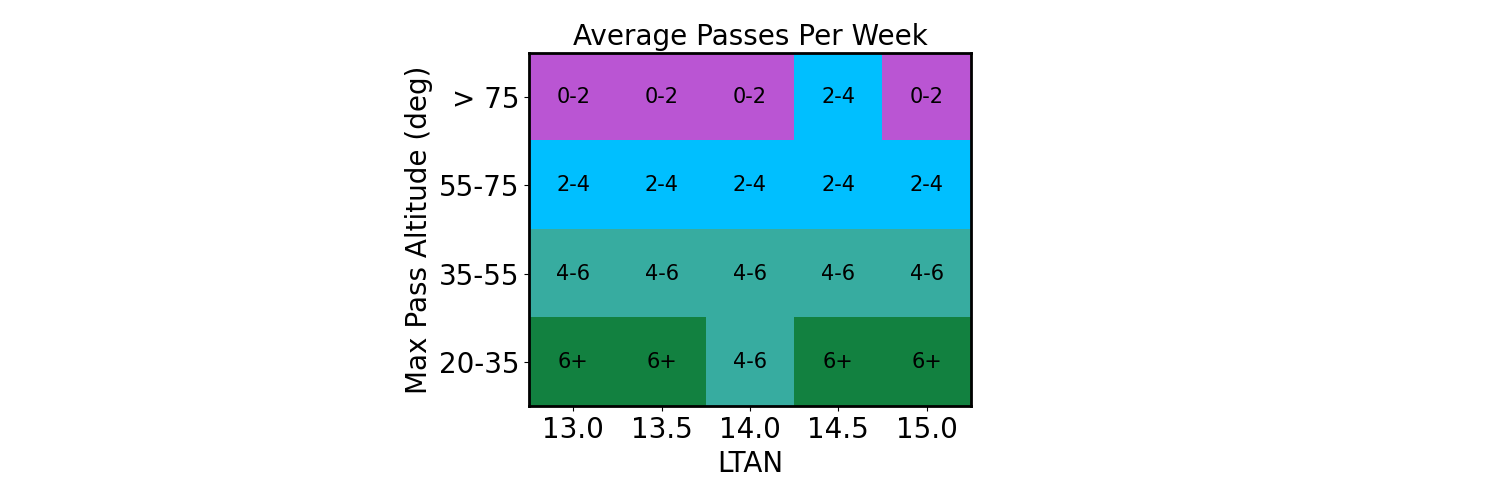

In [12]:
ltans = np.arange(12.5, 16, 0.5)
ylabels = ["20-35", "35-55", "55-75", "> 75"]
# Classification bins and labels
bins = [0, 2, 4, 6, 100]
labels = [0, 1, 2, 3, 4]  # Category IDs
descriptions = {
    1: "0-2",
    2: "2-4",
    3: "4-6",
    4: "6+"
}

colors = [ '#ba55d3',  
         '#00bfff',
        "#37aca0",  
        "#128140"]


categorized = classify_array(plot_events, bins, labels)
with plt.rc_context({'axes.labelsize': 20 , 'axes.linewidth': 2, 'xtick.labelsize': 20, 'ytick.labelsize': 20, 'legend.fontsize': 10, 'axes.titlesize': 20, 'font.size': 15}):

    plot_categorized_array(categorized, descriptions, colors, ltans, ylabels[::-1])
